In [1]:
import torch
import torch.nn.functional as F
from models import Create_nets
from datasets import get_dataloader
#from options import TrainOptions
from torchvision import models
import os
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import cv2
from utils.results import *
from matplotlib.cm import viridis
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from utils.dataloader import get_paths_mvtec
from datasets import ImageDataset_mvtec
from torch.utils.data import DataLoader
import copy

In [2]:
import os
import json

class TrainOptions:
    def __init__(self):
        self.exp_name = "DEV_USDR"
        self.epoch_start = 0
        self.epoch_num = 1
        self.factor = 1
        self.seed = 233
        self.fixed_seed_bool = True
        self.test_seed = 400
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.data_category = "screw"
        self.data_set = "mvtec"
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.results_dir = 'results'
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.1
        self.assumed_contamination_rate = 0.1
        self.mode = 'mvtec'
        self.development = False
        self.parser = None
        self.initialized = False


In [3]:
args = TrainOptions()
os.makedirs(args.results_dir, exist_ok=True)
os.makedirs(os.path.join(args.results_dir, args.data_set, f'contamination_{int(args.contamination_rate*100)}', f'{args.exp_name}-{args.data_category}', args.image_result_dir), exist_ok=True)
os.makedirs(os.path.join(args.results_dir, args.data_set, f'contamination_{int(args.contamination_rate*100)}', f'{args.exp_name}-{args.data_category}', args.model_result_dir), exist_ok=True)

try:
    with open(os.path.join('configurations', f'{args.data_set}.json'), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})
    
torch.manual_seed(args.seed)

## USDR

In [4]:
normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec(args,verbose=True)
DATA_PATH=os.path.join(args.data_root,args.data_category)
# combine good and anomalies
train_data=normal_images+sampled_anomalies_for_train
labels_train=[0]*len(normal_images)+[1]*len(sampled_anomalies_for_train)

category: screw, normals train:  320, anomalies test: 119, normal test: 41
anomalies test total:     {'manipulated_front': 24, 'scratch_head': 24, 'scratch_neck': 25, 'thread_side': 23, 'thread_top': 23}
anomalies test sampled:   {'manipulated_front': 6, 'scratch_head': 6, 'scratch_neck': 6, 'thread_side': 6, 'thread_top': 6}
anomalies test remaining: {'manipulated_front': 18, 'scratch_head': 18, 'scratch_neck': 19, 'thread_side': 17, 'thread_top': 17}


In [5]:
np.random.seed(args.seed)
N_samples = len(train_data)
print(N_samples)
idx = np.arange(N_samples)
np.random.shuffle(idx)

stride =45
window_size = 120
# Create train sets
shifts = np.floor(N_samples / stride)
train_sets = int(shifts)
print('train_sets: ', train_sets)
print('window_size: ', window_size)

train_ind_ls = []
for i in range(train_sets):
    train_ind_ls.append(idx[np.arange(i * stride, i * stride + window_size) % N_samples])

all_data_paths=[train_data[id]for id in idx]
all_data_set=ImageDataset_mvtec(args,DATA_PATH,mode='train',train_paths = all_data_paths,test_paths = None)
all_dataloader = DataLoader(all_data_set,batch_size=args.batch_size,shuffle=False,num_workers=args.n_cpu,drop_last=False)
recon_error_ls = []

## Preset model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
backbone = models.resnet18(pretrained=True).to(device)
backbone.eval()
outputs = []
def hook(module, input, output):
    outputs.append(output)
backbone.layer1[-1].register_forward_hook(hook)
backbone.layer2[-1].register_forward_hook(hook)
backbone.layer3[-1].register_forward_hook(hook)
criterion = nn.MSELoss()

def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
    return z


recon_error_ls = []



for j in range(train_sets):
    
    model_result_m=args.model_result_dir+'_j_'+str(j)
    
    EXPERIMENT_PATH = os.path.join(args.results_dir,args.data_set ,f'contamination_{int(args.contamination_rate*100)}',f'{args.exp_name}-{args.data_category}')
    SAVE_DIR= os.path.join(EXPERIMENT_PATH, model_result_m, 'checkpoint.pth')
    
    if not os.path.exists(os.path.join(EXPERIMENT_PATH, model_result_m)):
        os.makedirs(os.path.join(EXPERIMENT_PATH, model_result_m))

    paths_j = [train_data[idx] for idx in train_ind_ls[j]]
    dataset_j=ImageDataset_mvtec(args,DATA_PATH,mode='train',train_paths = paths_j, test_paths = None)
    train_j_dataloader = DataLoader(dataset_j, batch_size=2,shuffle=False,num_workers=8,drop_last=False)
    
    #train_dataloader, valid_loader ,test_dataloader = get_dataloader(args)

    ## Train model
    
    # #model....
    start_epoch = 0
    transformer = Create_nets(args)
    transformer = transformer.to(device)
    transformer.cuda()
    optimizer = torch.optim.Adam( transformer.parameters(), lr=args.lr, betas=(args.b1, args.b2))
    best_loss = 1e10
    
    #### TRAIN MODEL
    for epoch in range(start_epoch, args.epoch_num):
        avg_loss = 0
        avg_loss_scale = 0
        total = 0
        transformer.train()
        for i,(filename, batch) in enumerate(train_j_dataloader):
            
            inputs = batch.to(device)
            outputs = []
            optimizer.zero_grad()
            with torch.no_grad():
                _ = backbone(inputs)
                outputs = embedding_concat(embedding_concat(outputs[0],outputs[1]),outputs[2])
        
            recon, std = transformer(outputs)
            torch.cuda.empty_cache()

            loss = criterion(recon, outputs)
            loss_scale = criterion(std, torch.norm(recon - outputs, p = 2, dim = 1, keepdim = True).detach())
            (loss+loss_scale).backward()

            optimizer.step()
            torch.cuda.empty_cache()

            avg_loss += loss * inputs.size(0)
            avg_loss_scale += loss_scale * inputs.size(0)
            total += inputs.size(0)
            print(("\r[Epoch%d/%d]-[Batch%d/%d]-[Loss:%f]-[Loss_scale:%f]" %
                                                            (epoch+1, args.epoch_num,
                                                            i, len(train_j_dataloader),
                                                            avg_loss / total,
                                                            avg_loss_scale / total)))
        if best_loss > avg_loss and best_loss > loss:
            best_loss = avg_loss
            state_dict = {
                        'start_epoch':epoch,
                        #'optimizer':optimizer.state_dict(),
                        'transformer':transformer.state_dict(),
                        'args':args,
                        'best_loss':best_loss
                }
            torch.save(state_dict, SAVE_DIR)
            
    # EVALUATE ON TRAINING SET
    print("start evaluation on training set!")
    transformer.eval()
    score_map = []
    for i,(filename, batch) in enumerate(all_dataloader):
        with torch.no_grad():
            inputs = batch.to(device)
            outputs = []
            _ = backbone(inputs)
            outputs = embedding_concat(embedding_concat(outputs[0],outputs[1]),outputs[2])
            recon, std = transformer(outputs)
            
            
            
            batch_size, channels, width, height = recon.size()
            dist = torch.norm(recon - outputs, p = 2, dim = 1, keepdim = True).div(std.abs())
            dist = dist.view(batch_size, 1, width, height)
            patch_normed_score = []
            for j in range(4):
                patch_size = pow(4, j)
                patch_score = F.conv2d(input=dist, 
                    weight=(torch.ones(1,1,patch_size,patch_size) / (patch_size*patch_size)).to(device), 
                    bias=None, stride=patch_size, padding=0, dilation=1)
                patch_score = F.avg_pool2d(dist,patch_size,patch_size)
                patch_score = F.interpolate(patch_score, (width,height), mode='bilinear', align_corners=False)
                patch_normed_score.append(patch_score)
            score = torch.zeros(batch_size,1,64,64).to(device)
            for j in range(4):
                score = embedding_concat(score, patch_normed_score[j])
            
            score = F.conv2d(input=score, 
                    weight=torch.tensor([[[[0.0]],[[0.25]],[[0.25]],[[0.25]],[[0.25]]]]).to(device), 
                    bias=None, stride=1, padding=0, dilation=1)
            score = F.interpolate(score, (inputs.size(2),inputs.size(3)), mode='bilinear', align_corners=False)
            heatmap = score.repeat(1,3,1,1)
            score_map.append(score.cpu())

    
    scores = torch.cat(score_map,dim=0)
    
    # max_score = scores.max()
    # min_score = scores.min()
    # scores = (scores - min_score) / (max_score - min_score)
    
    img_scores = scores.view(scores.size(0),-1).max(dim=1)[0]
    recon_error_ls.append(img_scores)
        

scores = np.vstack(recon_error_ls)

for i in range(train_sets):
     scores[i, :] = (scores[i, :] - scores[i, train_ind_ls[i]].mean()) / scores[i, train_ind_ls[i]].std()
    
# Create boolean matrix for train and test points
scores_bool = np.zeros_like(scores, dtype=bool)

for i in range(train_sets):
    scores_bool[i, train_ind_ls[i]] = True
    
    
scores_infer = scores.copy()
scores_train = scores.copy()

scores_infer[scores_bool] = np.nan
scores_train[~scores_bool] = np.nan


# Check how much point is varying in train and test
scores_test_mean = np.nanmean(scores_infer,axis = 0)
scores_test_std = np.nanstd(scores_infer,axis = 0)
scores_train_mean = np.nanmean(scores_train,axis = 0)
scores_train_std = np.nanstd(scores_train,axis = 0)


indicator = np.abs(scores_test_mean - scores_train_mean)

resdict={'indicator':indicator,'idx':idx}
pd.DataFrame(resdict).to_pickle(os.path.join(EXPERIMENT_PATH,f'USDR_window:{window_size}_stride:{stride}.pkl'))

sorted_indices = np.argsort(indicator)#ascending order

# Print the indices
print(sorted_indices)
refined_data_set = [train_data[idx] for idx in sorted_indices[::-1]]
refined_data_set


350
train_sets:  7
window_size:  120


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but

[Epoch1/1]-[Batch0/60]-[Loss:0.314083]-[Loss_scale:141.022827]
[Epoch1/1]-[Batch1/60]-[Loss:0.268027]-[Loss_scale:120.184128]
[Epoch1/1]-[Batch2/60]-[Loss:0.233203]-[Loss_scale:104.456627]
[Epoch1/1]-[Batch3/60]-[Loss:0.204243]-[Loss_scale:91.412598]
[Epoch1/1]-[Batch4/60]-[Loss:0.181326]-[Loss_scale:81.111511]
[Epoch1/1]-[Batch5/60]-[Loss:0.163099]-[Loss_scale:72.933067]
[Epoch1/1]-[Batch6/60]-[Loss:0.148953]-[Loss_scale:66.590668]
[Epoch1/1]-[Batch7/60]-[Loss:0.138150]-[Loss_scale:61.749542]
[Epoch1/1]-[Batch8/60]-[Loss:0.129288]-[Loss_scale:57.778992]
[Epoch1/1]-[Batch9/60]-[Loss:0.122375]-[Loss_scale:54.680603]
[Epoch1/1]-[Batch10/60]-[Loss:0.116659]-[Loss_scale:52.118103]
[Epoch1/1]-[Batch11/60]-[Loss:0.111880]-[Loss_scale:49.974373]
[Epoch1/1]-[Batch12/60]-[Loss:0.107743]-[Loss_scale:48.117519]
[Epoch1/1]-[Batch13/60]-[Loss:0.104263]-[Loss_scale:46.553932]
[Epoch1/1]-[Batch14/60]-[Loss:0.101147]-[Loss_scale:45.153305]
[Epoch1/1]-[Batch15/60]-[Loss:0.098504]-[Loss_scale:43.963604]

['/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/051.png',
 '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/242.png',
 '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/test/scratch_neck/016.png',
 '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/222.png',
 '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/253.png',
 '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/247.png',
 '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/232.png',
 '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/267.png',
 '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/258.png',
 '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/076.png',
 '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/test/manipulated_front/015.png',
 '/home/bule/projects/datasets/mvtec_anomaly_detection/screw/train/good/175.png

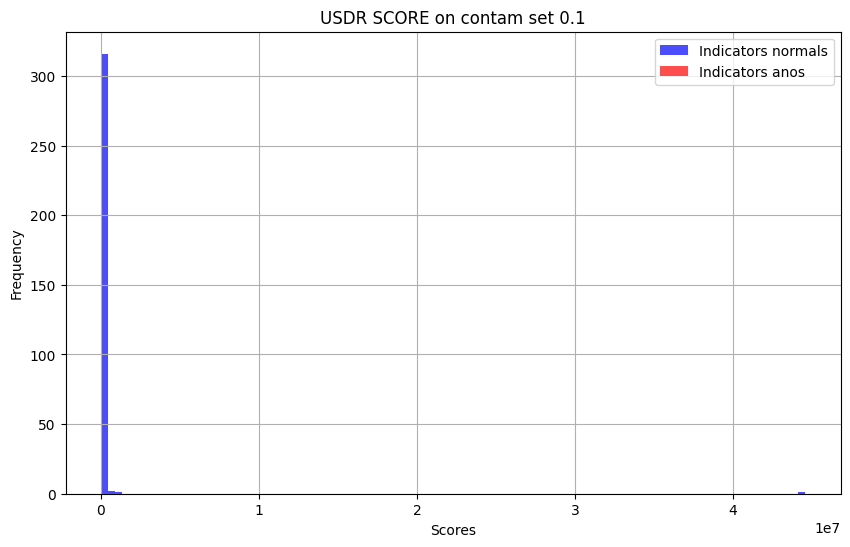

In [19]:

idx_labs=[labels_train[idx] for idx in idx]
indicator = np.abs(scores_test_mean - scores_train_mean)

score_0 = indicator[np.where(np.array(idx_labs) == 0)]
score_1 = indicator[np.where(np.array(idx_labs) == 1)]


plt.figure(figsize=(10, 6))
plt.hist(score_0, color='blue', bins=100, alpha=0.7, label='Indicators normals')
plt.hist(score_1, color='red', bins=100, alpha=0.7, label='Indicators anos')
plt.xlabel('Scores')
plt.ylabel('Frequency')

plt.title(f'USDR SCORE on contam set {args.contamination_rate}')
plt.legend()
plt.grid(True)
plt.show()

### SIMPLE REFINEMENT

In [7]:

args = TrainOptions()

args.epoch_num = 150
os.makedirs(args.results_dir, exist_ok=True)
os.makedirs(os.path.join(args.results_dir, args.data_set, f'contamination_{int(args.contamination_rate*100)}', f'{args.exp_name}-{args.data_category}', args.image_result_dir), exist_ok=True)
os.makedirs(os.path.join(args.results_dir, args.data_set, f'contamination_{int(args.contamination_rate*100)}', f'{args.exp_name}-{args.data_category}', args.model_result_dir), exist_ok=True)

try:
    with open(os.path.join('configurations', f'{args.data_set}.json'), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})
    
torch.manual_seed(args.seed)

model_result_m=args.model_result_dir+'_simpleref_'+str(j)
EXPERIMENT_PATH = os.path.join(args.results_dir,args.data_set ,f'contamination_{int(args.contamination_rate*100)}',f'{args.exp_name}-{args.data_category}')
SAVE_DIR= os.path.join(EXPERIMENT_PATH, model_result_m, 'checkpoint.pth')

if not os.path.exists(os.path.join(EXPERIMENT_PATH, model_result_m)):
    os.makedirs(os.path.join(EXPERIMENT_PATH, model_result_m))

## Train model

# #model....
start_epoch = 0
transformer = Create_nets(args)
transformer = transformer.to(device)
transformer.cuda()
optimizer = torch.optim.Adam( transformer.parameters(), lr=args.lr, betas=(args.b1, args.b2))
best_loss = 1e10

#### TRAIN MODEL
for epoch in range(start_epoch, args.epoch_num):
    avg_loss = 0
    avg_loss_scale = 0
    total = 0
    transformer.train()
    for i,(filename, batch) in enumerate(all_dataloader):
        
        inputs = batch.to(device)
        outputs = []
        optimizer.zero_grad()
        with torch.no_grad():
            _ = backbone(inputs)
            outputs = embedding_concat(embedding_concat(outputs[0],outputs[1]),outputs[2])
    
        recon, std = transformer(outputs)
        torch.cuda.empty_cache()

        loss = criterion(recon, outputs)
        loss_scale = criterion(std, torch.norm(recon - outputs, p = 2, dim = 1, keepdim = True).detach())
        (loss+loss_scale).backward()

        optimizer.step()
        torch.cuda.empty_cache()

        avg_loss += loss * inputs.size(0)
        avg_loss_scale += loss_scale * inputs.size(0)
        total += inputs.size(0)
        print(("\r[Epoch%d/%d]-[Batch%d/%d]-[Loss:%f]-[Loss_scale:%f]" %
                                                        (epoch+1, args.epoch_num,
                                                        i, len(train_j_dataloader),
                                                        avg_loss / total,
                                                        avg_loss_scale / total)))
    if best_loss > avg_loss and best_loss > loss:
        best_loss = avg_loss
        state_dict = {
                    'start_epoch':epoch,
                    #'optimizer':optimizer.state_dict(),
                    'transformer':transformer.state_dict(),
                    'args':args,
                    'best_loss':best_loss
            }
        torch.save(state_dict, SAVE_DIR)
        
# EVALUATE ON TRAINING SET
print("start evaluation on training set!")
transformer.eval()
score_map = []
for i,(filename, batch) in enumerate(all_dataloader):
    with torch.no_grad():
        inputs = batch.to(device)
        outputs = []
        _ = backbone(inputs)
        outputs = embedding_concat(embedding_concat(outputs[0],outputs[1]),outputs[2])
        recon, std = transformer(outputs)
        
        
        
        batch_size, channels, width, height = recon.size()
        dist = torch.norm(recon - outputs, p = 2, dim = 1, keepdim = True).div(std.abs())
        dist = dist.view(batch_size, 1, width, height)
        patch_normed_score = []
        for j in range(4):
            patch_size = pow(4, j)
            patch_score = F.conv2d(input=dist, 
                weight=(torch.ones(1,1,patch_size,patch_size) / (patch_size*patch_size)).to(device), 
                bias=None, stride=patch_size, padding=0, dilation=1)
            patch_score = F.avg_pool2d(dist,patch_size,patch_size)
            patch_score = F.interpolate(patch_score, (width,height), mode='bilinear', align_corners=False)
            patch_normed_score.append(patch_score)
        score = torch.zeros(batch_size,1,64,64).to(device)
        for j in range(4):
            score = embedding_concat(score, patch_normed_score[j])
        
        score = F.conv2d(input=score, 
                weight=torch.tensor([[[[0.0]],[[0.25]],[[0.25]],[[0.25]],[[0.25]]]]).to(device), 
                bias=None, stride=1, padding=0, dilation=1)
        score = F.interpolate(score, (inputs.size(2),inputs.size(3)), mode='bilinear', align_corners=False)
        heatmap = score.repeat(1,3,1,1)
        score_map.append(score.cpu())


score_map = torch.cat(score_map,dim=0)
max_score = score_map.max()
min_score = score_map.min()
scores = (score_map - min_score) / (max_score - min_score)
img_scores = scores.view(scores.size(0),-1).max(dim=1)[0]
recon_error_ls.append(img_scores)

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[Epoch1/150]-[Batch0/60]-[Loss:0.312791]-[Loss_scale:140.259323]
[Epoch1/150]-[Batch1/60]-[Loss:0.265995]-[Loss_scale:119.139725]
[Epoch1/150]-[Batch2/60]-[Loss:0.230320]-[Loss_scale:103.070877]
[Epoch1/150]-[Batch3/60]-[Loss:0.201202]-[Loss_scale:89.979889]
[Epoch1/150]-[Batch4/60]-[Loss:0.178357]-[Loss_scale:79.725304]
[Epoch1/150]-[Batch5/60]-[Loss:0.160702]-[Loss_scale:71.809319]
[Epoch1/150]-[Batch6/60]-[Loss:0.147257]-[Loss_scale:65.783752]
[Epoch1/150]-[Batch7/60]-[Loss:0.136671]-[Loss_scale:61.040749]
[Epoch1/150]-[Batch8/60]-[Loss:0.127939]-[Loss_scale:57.129795]
[Epoch1/150]-[Batch9/60]-[Loss:0.121253]-[Loss_scale:54.134132]
[Epoch1/150]-[Batch10/60]-[Loss:0.115545]-[Loss_scale:51.575653]
[Epoch1/150]-[Batch11/60]-[Loss:0.110891]-[Loss_scale:49.488277]
[Epoch1/150]-[Batch12/60]-[Loss:0.106924]-[Loss_scale:47.707485]
[Epoch1/150]-[Batch13/60]-[Loss:0.103504]-[Loss_scale:46.171070]
[Epoch1/150]-[Batch14/60]-[Loss:0.100422]-[Loss_scale:44.786598]
[Epoch1/150]-[Batch15/60]-[Loss:

KeyboardInterrupt: 